# SD201 project

- Create dataset from scraping with steam api
- Make apriori algorithm on bought games
- Make knn algorithm on hours played
- Use steam api to make recommendations to a player

# Formulate the question

Knowing the games someone bought and how many hours they played it on Steam, what are the other games they could like and thus potentially buy ?

# Finding the dataset

We'll first test the algorithms on an already existing dataset, and we will then try to create our own dataset with Steam's api.

We choose this dataset : https://www.kaggle.com/datasets/tamber/steam-video-games.  
Indeed, it gives us a huge amount of users with their bought and played games on Steam, which will enable us to predict what kind of games they like (supposing that the more someone plays a game, the more he likes it), 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('steam-200k.csv')

In [3]:
df.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [4]:
df.describe()

,151603712,1.0,0
count,1.999990e+05,199999.000000,199999.0
mean,1.036556e+08,17.874468,0.0
std,7.208084e+07,138.057292,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


The dataset cumulates 2 000 000 hours played, which seems enough, and we will check the number of users when the data will be a little bit cleaner.

# Cleaning the data

## Renaming the columns

In [5]:
df.columns = ['id','game','state','hours_played','0']
df.head()

,id,game,state,hours_played,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [6]:
df['id'].nunique()

12393

We have 12393 users in the dataset, which seems to be a good start to create recommendations.

## Removing the column always equals to 0

In [7]:
df = df.drop('0',axis=1)
df.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


## Look out for NaN values

In [8]:
df.isnull().values.any()

False

There are no NaN values in the dataset

## Separate games bought and games played

In [9]:
bought_games = df.loc[df['state']=='purchase']
played_games = df.loc[df['state']=='play']

For the bought_games, the hours_played has been set to 1 but it is irrelevant, so we can drop the column

In [10]:
bought_games = bought_games.drop(['hours_played','state'],axis=1)
bought_games.head()

,id,game
1,151603712,Fallout 4
3,151603712,Spore
5,151603712,Fallout New Vegas
7,151603712,Left 4 Dead 2
9,151603712,HuniePop


In [11]:
played_games = played_games.drop(['state'],axis=1)
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
4,151603712,Spore,14.9
6,151603712,Fallout New Vegas,12.1
8,151603712,Left 4 Dead 2,8.9


# Visualizing the data

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Density of hours played by player')

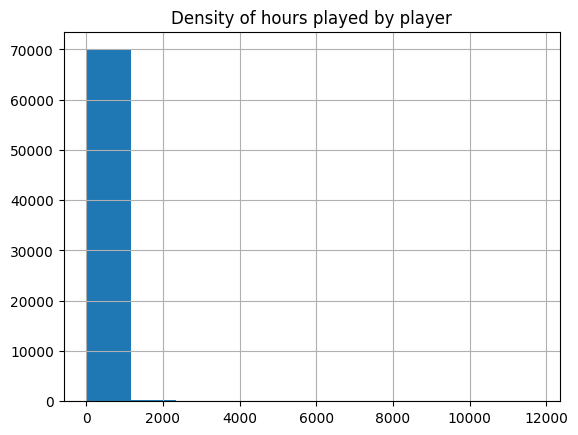

In [13]:
plt.figure()
played_games['hours_played'].hist()
plt.title('Density of hours played by player')

Text(0.5, 1.0, 'Density of games owned by player')

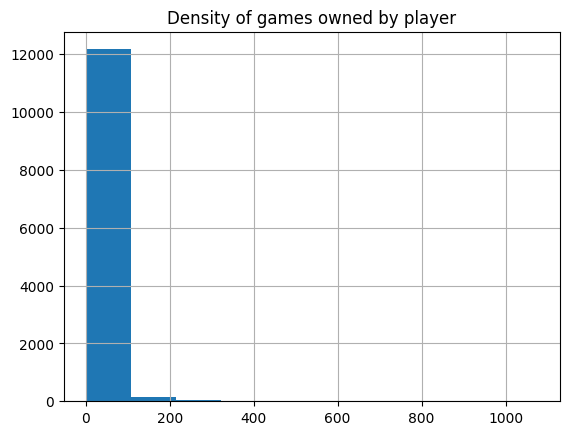

In [14]:
plt.figure()
bought_games.groupby(['id'])['game'].count().hist()
plt.title('Density of games owned by player')

It seems that the distribution is exponential, the majority of players only buy a few games, and play for a few hours. Let's check what happens for the outliers.

Text(0.5, 1.0, 'Density of hours played by outlier players')

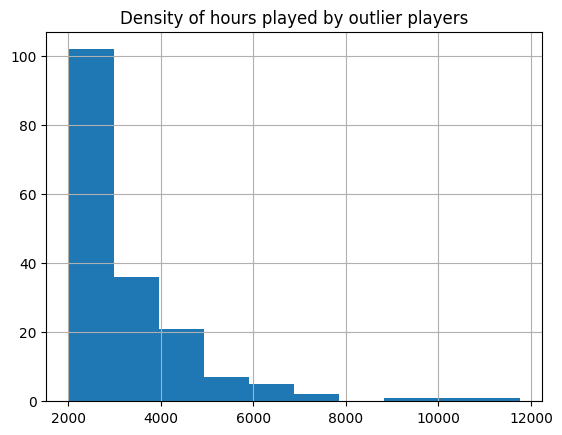

In [15]:
plt.figure()
played_games.loc[played_games['hours_played']>2000,'hours_played'].hist()
plt.title('Density of hours played by outlier players')

Text(0.5, 1.0, 'Density of games owned by outlier players')

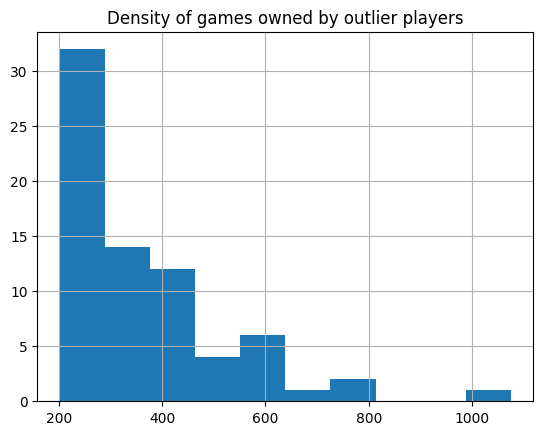

In [16]:
plt.figure()
bought_games.groupby(['id'])['game'].count().loc[bought_games.groupby(['id'])['game'].count()>200].hist()
plt.title('Density of games owned by outlier players')

Even for outliers, the exponential distribution seems to be verified.

# Technical ideas
## 1- Recommendations on games bought -> cluster players depending on the game they have bought
This problem, considering only the games that have been bought, is really similar to the problem of the market basket analysis, and we will thus try to use an apriori algorithm to solve it, which means deducing from the game bought by a person which other games people that buy those usually buy aswell.
## 2- Recommendations base on hours played
K-NN on players

## 1)

In [17]:
from mlxtend.frequent_patterns import apriori, association_rules

To apply the apriori algorithm, we need to rearrange the dataset, with a column for each game and one-hot-encoded lines

In [18]:
#Create lists of games for each player
bought_list = bought_games.groupby(['id'])['game'].apply(list)
bought_list.head()

id
5250      [Cities Skylines, Deus Ex Human Revolution, Po...
76767     [Counter-Strike, Call of Duty World at War, To...
86540     [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
103360    [Counter-Strike, Counter-Strike Condition Zero...
144736    [Counter-Strike, Day of Defeat, Deathmatch Cla...
Name: game, dtype: object

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
#One-hot-encode the lists
mlb = MultiLabelBinarizer()

bought_encoded = pd.DataFrame(mlb.fit_transform(bought_list),
                   columns=mlb.classes_)

#The id of the player is no more needed
bought_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
frq_items = apriori(bought_encoded, min_support = 0.02, use_colnames = True)
  
# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 0.8)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head()

/home/hyraeth/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Arma 2 Operation Arrowhead Beta (Obsolete)),(Arma 2 Operation Arrowhead),0.020173,0.020173,0.020173,1.0,49.572000,0.019766,inf
1,(Arma 2 Operation Arrowhead),(Arma 2 Operation Arrowhead Beta (Obsolete)),0.020173,0.020173,0.020173,1.0,49.572000,0.019766,inf
6,(Call of Duty Black Ops - Multiplayer),(Call of Duty Black Ops),0.020495,0.020495,0.020495,1.0,48.791339,0.020075,inf
7,(Call of Duty Black Ops),(Call of Duty Black Ops - Multiplayer),0.020495,0.020495,0.020495,1.0,48.791339,0.020075,inf
2110,"(Half-Life Blue Shift, Deathmatch Classic)","(Ricochet, Half-Life Opposing Force)",0.023400,0.023400,0.023400,1.0,42.734483,0.022853,inf


In [21]:
len(rules)

7266

In [22]:
rules.iloc[75]

antecedents           (Team Fortress Classic, Half-Life, Ricochet)
consequents             (Half-Life Blue Shift, Deathmatch Classic)
antecedent support                                          0.0234
consequent support                                          0.0234
support                                                     0.0234
confidence                                                     1.0
lift                                                     42.734483
leverage                                                  0.022853
conviction                                                     inf
Name: 4070, dtype: object

**Note : tests avec les frequent itemsets -> séparer en training/test, pour le test : supprimer un élément du basket, et prédire cet élément avec les règles -> utiliser les métriques classiques de prédiction**

# 2)
The aim of the algorithm is to predict a list of games someone may like knowing how much he played to other games.
It means that the feature we want to predict is a list of games, and the features used to do so are, for each game in the database, the amount of hours spent playing this game.

We then want X, Y like this :  
X = [0,0,...,0,5.2,0,10,...]  
Y = [0,1,1,0,0,1,...] (the one-encoded vector of the games liked) 

To determine the k neighbors, we will use the L2 distance on the vectors of hours played for each game.  
With this distance, firstly people that played a lot the same games will be near from each other, but it will also cluster types of players : those who play a lot of different games will be together, and the niche player will be separated.  

To make a prediction, we will compute using this distance the k neighbors of a player, and make a prediction.  
For this prediction, the k-nn algorithm usually choses the majority class of the neighbors. Thus, we could define a class as the one-hot-encoding of the games played by the user. However, this may lead to 1 class per neighbor, as it is highly possible that every player in the neighborhood, even if they are close one to each other, have tried a game the other ones never played to.  
That's why we choose as a result to give the intersection of all the games played by the neighbors. This will guarantee that the games resulting will be chosen because they are characteristical of the neighborhood.  
Obviously, we will remove from the result the games already played by the initial player (we don't want to recommand to someone a game he already played for 200 hours...)

In [23]:
bought_list.head()

id
5250      [Cities Skylines, Deus Ex Human Revolution, Po...
76767     [Counter-Strike, Call of Duty World at War, To...
86540     [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
103360    [Counter-Strike, Counter-Strike Condition Zero...
144736    [Counter-Strike, Day of Defeat, Deathmatch Cla...
Name: game, dtype: object

In [24]:
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
4,151603712,Spore,14.9
6,151603712,Fallout New Vegas,12.1
8,151603712,Left 4 Dead 2,8.9


In [25]:
#Get a dict of games and hours played for each id
played_dict = played_games.groupby('id').apply(lambda g : dict(zip(g['game'], g['hours_played'])))
played_dict.head()

id
5250      {'Cities Skylines': 144.0, 'Deus Ex Human Revo...
76767     {'Counter-Strike': 365.0, 'Call of Duty World ...
86540     {'The Elder Scrolls V Skyrim': 113.0, 'Audiosu...
144736                              {'Counter-Strike': 0.1}
181212    {'Counter-Strike': 1.8, 'Half-Life 2 Lost Coas...
dtype: object

In [26]:
#Create vectors of hours played 
hours_encoded = played_dict.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded = hours_encoded.fillna(0)
#We drop the ids because they are not useful anymore
hours_encoded = hours_encoded.reset_index(drop=True)
#Sort by name of games
hours_encoded = hours_encoded.reindex(sorted(hours_encoded.columns),axis=1)
hours_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Get the list of games
games_list = list(hours_encoded.columns)
games_list.sort()
len(games_list)

3600

In [28]:
#We now create our "classes" : the list of games played by each player
played_list = played_games.groupby('id')['game'].apply(list).reset_index(drop=True)
played_list.head()

0    [Cities Skylines, Deus Ex Human Revolution, Po...
1    [Counter-Strike, Call of Duty World at War, To...
2    [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
3                                     [Counter-Strike]
4             [Counter-Strike, Half-Life 2 Lost Coast]
Name: game, dtype: object

In [29]:
#And we one-hot encode them
from sklearn.preprocessing import MultiLabelBinarizer
#One-hot-encode the lists
mlb = MultiLabelBinarizer()

played_encoded = pd.DataFrame(mlb.fit_transform(played_list),
                   columns=mlb.classes_)

played_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Create training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hours_encoded, played_encoded, test_size=0.2, random_state=42)

Let's check if our data and labels are coherent

In [31]:
X_train.iloc[150]

007 Legends                                                   0.0
0RBITALIS                                                     0.0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)    0.0
10 Second Ninja                                               0.0
10,000,000                                                    0.0
                                                             ... 
rymdkapsel                                                    0.0
sZone-Online                                                  0.0
the static speaks my name                                     0.0
theHunter                                                     0.0
theHunter Primal                                              0.0
Name: 10527, Length: 3600, dtype: float64

In [32]:
#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player(i):
    return [games_list[index] for index in list(np.asarray(y_train.iloc[i]).nonzero())[0]]

games_of_player(150)

["Assassin's Creed Revelations",
 'Borderlands',
 'Counter-Strike Global Offensive',
 'Darksiders',
 'Darksiders II',
 "Deus Ex Human Revolution - Director's Cut",
 'Fallout 3',
 'Fallout New Vegas',
 'Half-Life 2',
 'Hard Reset',
 'Hitman Codename 47',
 'Metro 2033',
 'ORION Prelude',
 'PROTOTYPE 2',
 'Remember Me']

In [33]:
X_train.iloc[150][['Counter-Strike Global Offensive','Fallout New Vegas','Borderlands']]

Counter-Strike Global Offensive    261.0
Fallout New Vegas                   24.0
Borderlands                          9.0
Name: 10527, dtype: float64

It seems clean! Let's implement the knn algorithm

In [34]:
from sklearn.neighbors import KNeighborsClassifier

We will choose 100 neighbors. As we have almost 10000 users, it means we link a player to 1% of the dataset, which seems to be a fair choice.

In [35]:
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=100)

In [36]:
preds = neigh.predict([X_test.iloc[400]])

/home/hyraeth/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [37]:
preds[0].nonzero()

(array([922]),)

In [38]:
games_list[922]

'Dota 2'

In [39]:
kn = neigh.kneighbors([X_test.iloc[400]])

/home/hyraeth/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [40]:
kn

(array([[4.85077313, 4.85077313, 4.85180379, 4.85180379, 4.85180379,
         4.85180379, 4.85180379, 4.85489444, 4.85489444, 4.85489444,
         4.85489444, 4.85489444, 4.85489444, 4.85489444, 4.86004115,
         4.86004115, 4.86004115, 4.86004115, 4.86004115, 4.86004115,
         4.86004115, 4.86004115, 4.86106984, 4.86723741, 4.86723741,
         4.86723741, 4.86723741, 4.86723741, 4.86723741, 4.87647414,
         4.87647414, 4.87647414, 4.87647414, 4.87647414, 4.87647414,
         4.87647414, 4.87647414, 4.87647414, 4.87647414, 4.87647414,
         4.88773976, 4.88773976, 4.88773976, 4.88773976, 4.88773976,
         4.88773976, 4.88773976, 4.9010203 , 4.9010203 , 4.9010203 ,
         4.9010203 , 4.9010203 , 4.9010203 , 4.9010203 , 4.9010203 ,
         4.9010203 , 4.9010203 , 4.91629942, 4.91629942, 4.91629942,
         4.91629942, 4.91629942, 4.92138192, 4.93355855, 4.93355855,
         4.93355855, 4.93355855, 4.93355855, 4.93355855, 4.93355855,
         4.93355855, 4.952777  , 4

In [41]:
games_of_player(5163)

['Dota 2']

In [42]:
X_test.iloc[400]['Dota 2']

9.7

In [43]:
X_train.iloc[5163]['Dota 2']

9.7

### Frequent itemset implementation

We want to see how well we can recommend games using frequent itemset

In [44]:
grouped = played_games.drop('hours_played', axis=1)
grouped = grouped.groupby('id')['game'].apply(list).reset_index(name='games')
grouped['games']



0        [Cities Skylines, Deus Ex Human Revolution, Po...
1        [Counter-Strike, Call of Duty World at War, To...
2        [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
3                                         [Counter-Strike]
4                 [Counter-Strike, Half-Life 2 Lost Coast]
                               ...                        
11345                                             [Dota 2]
11346                                  [Mitos.is The Game]
11347                       [Age of Empires II HD Edition]
11348                                             [Dota 2]
11349                                             [Dota 2]
Name: games, Length: 11350, dtype: object

In [45]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(grouped['games']).transform(grouped['games'])
df = pd.DataFrame(te_ary, columns=te.columns_)
df
fis = apriori(df, min_support=0.02, use_colnames=True)
fis


,support,itemsets
0,0.025463,(Alien Swarm)
1,0.034009,(Borderlands 2)
2,0.020000,(Call of Duty Black Ops)
3,0.026167,(Call of Duty Modern Warfare 2)
4,0.025639,(Call of Duty Modern Warfare 2 - Multiplayer)
...,...,...
68,0.022907,"(Team Fortress 2, Counter-Strike Global Offens..."
69,0.021145,"(Team Fortress 2, Garry's Mod, Dota 2)"
70,0.023172,"(Team Fortress 2, Dota 2, Left 4 Dead 2)"
71,0.022555,"(Team Fortress 2, Dota 2, Unturned)"


In [46]:
association_rules(fis, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Borderlands 2),(Team Fortress 2),0.034009,0.204670,0.020969,0.616580,3.012564,0.014009,2.074308
1,(Call of Duty Modern Warfare 2),(Call of Duty Modern Warfare 2 - Multiplayer),0.026167,0.025639,0.022731,0.868687,33.881773,0.022060,7.420136
2,(Call of Duty Modern Warfare 2 - Multiplayer),(Call of Duty Modern Warfare 2),0.025639,0.026167,0.022731,0.886598,33.881773,0.022060,8.587433
3,(Garry's Mod),(Counter-Strike Global Offensive),0.058678,0.121322,0.033304,0.567568,4.678208,0.026185,2.031944
4,(PAYDAY 2),(Counter-Strike Global Offensive),0.034361,0.121322,0.023877,0.694872,5.727520,0.019708,2.879702
5,(Terraria),(Counter-Strike Global Offensive),0.040529,0.121322,0.020881,0.515217,4.246708,0.015964,1.812520
6,(Warframe),(Dota 2),0.037357,0.426520,0.020264,0.542453,1.271812,0.004331,1.253379
7,(Garry's Mod),(Team Fortress 2),0.058678,0.204670,0.040088,0.683183,3.337981,0.028078,2.510379
8,(Portal 2),(Left 4 Dead 2),0.039912,0.070573,0.020352,0.509934,7.225653,0.017536,1.896534
9,(Left 4 Dead 2),(Team Fortress 2),0.070573,0.204670,0.040264,0.570537,2.787599,0.025820,1.851918


On peut remarquer que pour des supports allant de 10% à 5% on obtient presque uniquement les jeux les plus joués. Ce qui n'est pas étonnant comme on n'a pas filtré selon les temps de jeux. Obtenir une recommendation par association semble donc être futile.
On va voir s'il est possible de faire .
On va déjà faire rentrer le temps de jeu en paramètre : Si un joueur n'a pas plus d'heure de jeu que la moyenne pour un certain jeu, on ne le prend pas en compte.

In [53]:
avg = played_games.groupby('game')['hours_played'].apply(np.average).reset_index(name='avg_hours_played')
avg


,game,avg_hours_played
0,007 Legends,0.700000
1,0RBITALIS,0.400000
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,4.000000
3,10 Second Ninja,2.950000
4,"10,000,000",3.600000
...,...,...
3595,rymdkapsel,1.100000
3596,sZone-Online,0.977586
3597,the static speaks my name,0.250000
3598,theHunter,2.493548


In [48]:
#Dictionnary of average time played
avg_dict = avg.set_index('game').to_dict()['avg_hours_played']
avg_dict

{'007 Legends': 0.7,
 '0RBITALIS': 0.39999999999999997,
 '1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)': 4.0,
 '10 Second Ninja': 2.95,
 '10,000,000': 3.6,
 '100% Orange Juice': 8.700000000000001,
 '1000 Amps': 0.1,
 '12 Labours of Hercules': 4.957142857142856,
 '12 Labours of Hercules II The Cretan Bull': 4.2875,
 '12 Labours of Hercules III Girl Power': 6.533333333333334,
 '140': 1.26,
 '15 Days': 0.5,
 '16bit Trader': 4.45,
 '1701 A.D. Sunken Dragon': 0.6,
 '18 Wheels of Steel American Long Haul': 5.8,
 '1953 NATO vs Warsaw Pact': 5.9,
 '1Quest': 2.7,
 '3 Stars of Destiny': 4.7,
 '3089 -- Futuristic Action RPG': 0.3,
 '3D Mini Golf': 1.0,
 '3DMark': 13.377777777777778,
 '3DMark 11': 3.0,
 '3DMark Vantage': 21.0,
 '4 Elements': 14.85,
 '404Sight': 0.5285714285714286,
 '500 Years Act 1': 3.0,
 '60 Seconds!': 1.86,
 '7 Days to Die': 41.586734693877546,
 '8BitBoy': 3.4,
 '8BitMMO': 0.4555555555555555,
 '9 Clues 2 The Ward': 5.1,
 '9 Clues The Secret of Serpent Creek': 2.8,

In [49]:
#To get the avg time played for a game
avg_dict['Dota 2']

202.78549886387108

In [63]:
#Select only the rows where players played more than average
played_games_sup_avg = played_games.loc[played_games['hours_played'] > played_games['game'].astype(str).map(avg_dict)]
played_games_sup_avg

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
14,151603712,Poly Bridge,7.5
68,59945701,Ultra Street Fighter IV,238.0
70,59945701,FINAL FANTASY XIII,84.0
...,...,...,...
199972,128470551,Arma 2 DayZ Mod,22.0
199974,128470551,Antichamber,16.8
199976,128470551,Risk of Rain,15.4
199978,128470551,OlliOlli,10.8


In [66]:
g = played_games_sup_avg.groupby('id')['game'].apply(list).reset_index(name='games')
g['games']
te_ary = te.fit(g['games']).transform(g['games'])
df2 = pd.DataFrame(te_ary, columns=te.columns_)
df2
fis2 = apriori(df2, min_support=0.002, use_colnames=True)
fis2

,support,itemsets
0,0.005186,(7 Days to Die)
1,0.002122,(8BitMMO)
2,0.003300,(APB Reloaded)
3,0.009430,(ARK Survival Evolved)
4,0.005893,(Ace of Spades)
...,...,...
998,0.002357,"(Team Fortress 2, Terraria, Portal 2)"
999,0.002122,"(Total War ATTILA, Total War ROME II - Emperor..."
1000,0.002122,"(Half-Life 2 Lost Coast, Half-Life 2 Episode T..."
1001,0.002593,"(Half-Life 2 Episode Two, Half-Life 2, Half-Li..."


In [68]:
association_rules(fis2, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(AdVenture Capitalist),(Counter-Strike Global Offensive),0.007544,0.093352,0.002593,0.343750,3.682292,0.001889,1.381559
1,(Alien Swarm),(Team Fortress 2),0.019566,0.081094,0.007779,0.397590,4.902844,0.006193,1.525384
2,(Arma 2),(Arma 2 Operation Arrowhead),0.006836,0.010844,0.002593,0.379310,34.979010,0.002519,1.593640
3,(Arma 2 Operation Arrowhead),(Counter-Strike Global Offensive),0.010844,0.093352,0.004243,0.391304,4.191700,0.003231,1.489493
4,(BLOCKADE 3D),(Unturned),0.007308,0.059642,0.002357,0.322581,5.408645,0.001922,1.388148
...,...,...,...,...,...,...,...,...,...
295,"(Half-Life 2, Portal 2, Portal)",(Half-Life 2 Episode Two),0.004008,0.013437,0.002357,0.588235,43.777090,0.002304,2.395939
296,"(Half-Life 2 Episode Two, Portal 2)","(Half-Life 2, Portal)",0.003536,0.007779,0.002357,0.666667,85.696970,0.002330,2.976662
297,"(Half-Life 2 Episode Two, Portal)","(Half-Life 2, Portal 2)",0.005893,0.005893,0.002357,0.400000,67.872000,0.002323,1.656844
298,"(Half-Life 2, Portal 2)","(Half-Life 2 Episode Two, Portal)",0.005893,0.005893,0.002357,0.400000,67.872000,0.002323,1.656844
